In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import chex
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any, Dict
from flax.training.train_state import TrainState
import distrax

from jaxmarl import make
from jaxmarl.wrappers.baselines import (
    SMAXLogWrapper,
    MPELogWrapper,
    LogWrapper,
    CTRolloutManager,
)
from jaxmarl.environments.smax import map_name_to_scenario, HeuristicEnemySMAX, LearnedPolicyEnemySMAX
from jaxmarl.environments.smax.heuristic_enemy_smax_env import EnemySMAX
from jaxmarl.viz.visualizer import Visualizer, SMAXVisualizer

import functools
from functools import partial
import time
import os
import matplotlib.pyplot as plt

from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, compute_euclidean_centroids, MapElitesRepertoire
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.plotting import plot_map_elites_results
from qdax.utils.metrics import CSVLogger, default_qd_metrics



from dataclasses import dataclass

from qdax.core.emitters.repertoire_selectors.selector import Selector
from qdax.core.emitters.qpg_emitter import QualityPGConfig, QualityPGEmitterState
from qdax.tasks.brax.v1.envs.base_env import QDEnv

from qdax.core.emitters.multi_emitter import MultiEmitter
from qdax.core.containers.ga_repertoire import GARepertoire
from qdax.core.containers.repertoire import Repertoire
from qdax.core.emitters.emitter import Emitter

from qdax.core.emitters.pga_me_emitter import PGAMEConfig, PGAMEEmitter

import flashbax as fbx
## Brax version conflict with JaxMARL(0.10.3) and QDax(0.10.4 / 0.12.3)

In [2]:
from typing import Callable, Optional, Tuple
from qdax.custom_types import (
    Descriptor,
    EnvState,
    ExtraScores,
    Fitness,
    Genotype,
    Observation,
    Params,
    RNGKey,
)

In [3]:
config = {    
    # valid for iql, vdn, qmix
    "TOTAL_TIMESTEPS": 10e7, #1e7,
    "NUM_ENVS": 16, #16,
    "NUM_STEPS": 100,
    "BUFFER_SIZE": 12000, #5000,
    "BUFFER_BATCH_SIZE": 32,
    "HIDDEN_SIZE": 256, #64, #512,
    "MIXER_EMBEDDING_DIM": 16, #64,
    "MIXER_HYPERNET_HIDDEN_DIM": 64, #256,
    "MIXER_INIT_SCALE": 0.001,
    "EPS_START": 1.0,
    "EPS_FINISH": 0.05,
    "EPS_DECAY": 0.1, # percentage of updates
    "MAX_GRAD_NORM": 10,
    "TARGET_UPDATE_INTERVAL": 10, #10,
    "TAU": 0.1, #1.,
    "NUM_EPOCHS": 8,
    "LR": 0.00005,
    "LEARNING_STARTS": 10000, # timesteps
    "LR_LINEAR_DECAY": False,
    "GAMMA": 0.99,
    "REW_SCALE": 10., # scale the reward to the original scale of SMAC

    # ENV
    "ENV_NAME": "HeuristicEnemySMAX",
    #"MAP_NAME": "3s_vs_5z",
    #"MAP_NAME":"smacv2_5_units", # 5 random units for each size
    "MAP_NAME": "2s3z",
    #"MAP_NAME": "5m_vs_6m",
    "ENV_KWARGS": {
        "see_enemy_actions": True,
        "walls_cause_death": True,
        "attack_mode": "closest", # uncomment when using heuristic policy
        #"won_battle_bonus": 10.0, # To test if increasing winning reward gets solution to beat enemy
    },

    "NUM_SEEDS": 1, # number of vmapped seeds (not used)
    "SEED": 88,

    "HYP_TUNE": False, # perform hyp tune

    # evaluate
    "TEST_DURING_TRAINING": False, #True,
    "TEST_INTERVAL": 0.05, # as a fraction of updates, i.e. log every 5% of training process
    "TEST_NUM_STEPS": 128,
    "TEST_NUM_ENVS": 512, # number of episodes to average over, can affect performance
}
batch_size = 5# 128 # Num of offsprings 
#env_name = 'walker2d_uni'
episode_length = config["NUM_STEPS"] #128  # NUM_STEPS
num_iterations = int(config["TOTAL_TIMESTEPS"] / (batch_size * config["NUM_ENVS"] * config["NUM_STEPS"]))
seed = 88 
policy_hidden_layer_sizes = (128, 128, 128) #(64, 64)
iso_sigma = 0.005 #0.005 
line_sigma = 0.05 #0.05 
num_init_cvt_samples = 20000 #50000 
num_centroids = 1024 #1024 
min_descriptor = 0. 
max_descriptor = 1.0 
number_of_descriptors=2


proportion_mutation_ga = 0.5 

# IQL params
env_batch_size = batch_size #100 
replay_buffer_size = config["BUFFER_SIZE"] #1000000 
critic_hidden_layer_size = (256, 256) 
critic_learning_rate = 3e-4 
greedy_learning_rate = 3e-4 
policy_learning_rate = 0.00005 #1e-3 
noise_clip = 0.5
policy_noise = 0.2 
discount = config["GAMMA"] #0.99 
reward_scaling = 1.0 
transitions_batch_size = config["BUFFER_BATCH_SIZE"] #256 
soft_tau_update = 0.005
num_critic_training_steps = 300 
num_pg_training_steps = 1 #100 
policy_delay = 2

# Define the PG-emitter config
@dataclass
class CustomPGAMEConfig(PGAMEConfig):
    num_envs: Any = None
    num_steps: Any = None
    target_update_interval: Any = None
    tau: Any = None

pga_emitter_config = CustomPGAMEConfig(
    env_batch_size=env_batch_size,
    batch_size=transitions_batch_size,
    proportion_mutation_ga=proportion_mutation_ga,
    critic_hidden_layer_size=critic_hidden_layer_size,
    critic_learning_rate=critic_learning_rate,
    greedy_learning_rate=greedy_learning_rate,
    policy_learning_rate=policy_learning_rate,
    noise_clip=noise_clip,
    policy_noise=policy_noise,
    discount=discount,
    reward_scaling=reward_scaling,
    replay_buffer_size=replay_buffer_size,
    soft_tau_update=soft_tau_update,
    num_critic_training_steps=num_critic_training_steps,
    num_pg_training_steps=num_pg_training_steps,
    policy_delay=policy_delay,

    num_envs = config["NUM_ENVS"],
    num_steps = config["NUM_STEPS"],
    target_update_interval = config["TARGET_UPDATE_INTERVAL"],
    tau = config["TAU"],
)


In [ ]:
class ScannedRNN(nn.Module):

    @partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, carry, x):
        """Applies the module."""
        rnn_state = carry
        ins, resets = x
        hidden_size = ins.shape[-1]
        rnn_state = jnp.where(
            resets[:, np.newaxis],
            self.initialize_carry(hidden_size, *ins.shape[:-1]),
            rnn_state,
        )
        new_rnn_state, y = nn.GRUCell(hidden_size)(rnn_state, ins)
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(hidden_size, *batch_size):
        # Use a dummy key since the default state init fn is just zeros.
        return nn.GRUCell(hidden_size, parent=None).initialize_carry(
            jax.random.PRNGKey(0), (*batch_size, hidden_size)
        )


class RNNQNetwork(nn.Module):
    # homogenous agent for parameters sharing, assumes all agents have same obs and action dim
    action_dim: int
    hidden_dim: int
    init_scale: float = 1.0

    @nn.compact
    def __call__(self, hidden, obs, dones):
        embedding = nn.Dense(
            self.hidden_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(obs)
        embedding = nn.relu(embedding)

        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNN()(hidden, rnn_in)

        q_vals = nn.Dense(
            self.action_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(embedding)

        return hidden, q_vals
    

class HyperNetwork(nn.Module):
    """HyperNetwork for generating weights of QMix' mixing network."""

    hidden_dim: int
    output_dim: int
    init_scale: float

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(
            self.hidden_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(x)
        x = nn.relu(x)
        x = nn.Dense(
            self.output_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(x)
        return x


class MixingNetwork(nn.Module):
    """
    Mixing network for projecting individual agent Q-values into Q_tot. Follows the original QMix implementation.
    """

    embedding_dim: int
    hypernet_hidden_dim: int
    init_scale: float

    @nn.compact
    def __call__(self, q_vals, states):

        n_agents, time_steps, batch_size = q_vals.shape
        q_vals = jnp.transpose(q_vals, (1, 2, 0))  # (time_steps, batch_size, n_agents)

        # hypernetwork
        w_1 = HyperNetwork(
            hidden_dim=self.hypernet_hidden_dim,
            output_dim=self.embedding_dim * n_agents,
            init_scale=self.init_scale,
        )(states)
        b_1 = nn.Dense(
            self.embedding_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(states)
        w_2 = HyperNetwork(
            hidden_dim=self.hypernet_hidden_dim,
            output_dim=self.embedding_dim,
            init_scale=self.init_scale,
        )(states)
        b_2 = HyperNetwork(
            hidden_dim=self.embedding_dim, output_dim=1, init_scale=self.init_scale
        )(states)

        # monotonicity and reshaping
        w_1 = jnp.abs(w_1.reshape(time_steps, batch_size, n_agents, self.embedding_dim))
        b_1 = b_1.reshape(time_steps, batch_size, 1, self.embedding_dim)
        w_2 = jnp.abs(w_2.reshape(time_steps, batch_size, self.embedding_dim, 1))
        b_2 = b_2.reshape(time_steps, batch_size, 1, 1)

        # mix
        hidden = nn.elu(jnp.matmul(q_vals[:, :, None, :], w_1) + b_1)
        q_tot = jnp.matmul(hidden, w_2) + b_2

        return q_tot.squeeze()  # (time_steps, batch_size)

In [ ]:

class Transition(NamedTuple):
    #global_done: jnp.ndarray
    #reward: jnp.ndarray
    env_state: jnp.ndarray
    infos: jnp.ndarray

@chex.dataclass(frozen=True)
class Timestep:
    obs: dict
    actions: dict
    rewards: dict
    dones: dict
    avail_actions: dict


class CustomTrainState(TrainState):
    target_network_params: Any
    timesteps: int = 0
    n_updates: int = 0
    grad_steps: int = 0


In [ ]:
# Init environment
from flax.serialization import from_bytes # For loading pretrained params

#env = environments.create(env_name, episode_length=episode_length)
scenario = map_name_to_scenario(config["MAP_NAME"])
env = HeuristicEnemySMAX(scenario=scenario, **config["ENV_KWARGS"])
env = SMAXLogWrapper(env)
wrapped_env = CTRolloutManager(env, batch_size=config["NUM_ENVS"])

rng = jax.random.PRNGKey(config["SEED"])
reset_fn = jax.jit(wrapped_env.batch_reset)
#reset_fn = jax.jit(env.reset)

config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
config["NUM_UPDATES"] = (
    config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
)


# Init a random key
key = jax.random.key(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_space(env.agents[0]).n,) # Not actually used
#policy_network = ActorRNN(env.action_space(env.agents[0]).n, config=config)
policy_network = RNNQNetwork(
            action_dim=wrapped_env.max_action_space,
            hidden_dim=config["HIDDEN_SIZE"],
        )

# Init mixer used in qmix
mixer = MixingNetwork(
    config["MIXER_EMBEDDING_DIM"],
    config["MIXER_HYPERNET_HIDDEN_DIM"],
    config["MIXER_INIT_SCALE"],
)

# Init population of controllers
key, subkey = jax.random.split(key)
init_x = (
    jnp.zeros(
        (1, 1, wrapped_env.obs_size)
    ),  # (time_step, batch_size, obs_size)
    jnp.zeros((1, 1)),  # (time_step, batch size)
)
init_hstate = ScannedRNN.initialize_carry(
    config["HIDDEN_SIZE"], 1
)  # (batch_size, hidden_dim)

keys = jax.random.split(subkey, batch_size-1) # subtract 1 from batch size for loaded params added later


# Add leading batch dim and broadcast fake hidden state
fake_hstate = jnp.broadcast_to(jnp.expand_dims(init_hstate, 0), (batch_size-1, *init_hstate.shape))  # [batch_size, H]
# Same for each element in init_x tuple (assuming init_x is a tuple of arrays)
fake_x = tuple(
    jnp.broadcast_to(jnp.expand_dims(x, 0), (batch_size-1, *x.shape)) for x in init_x
)

# Load trained parameters
dummy_params = policy_network.init(key, init_hstate, *init_x)
with open("/vol/bitbucket/eww24/Masters_project/model_params/trained_qmix_params_v2.msgpack", "rb") as f:
    loaded_agent_params = from_bytes(dummy_params, f.read())
print("Loaded agent params")

#network_params = policy_network.init(subkey, init_hstate, init_x)
agent_params = jax.vmap(
    policy_network.init
)(keys, fake_hstate, *fake_x)

# init mixer
def _env_sample_step(env_state, unused):
    rng, key_a, key_s = jax.random.split(
        jax.random.PRNGKey(0), 3
    )  # use a dummy rng here
    key_a = jax.random.split(key_a, env.num_agents)
    actions = {
        agent: wrapped_env.batch_sample(key_a[i], agent)
        for i, agent in enumerate(env.agents)
    }
    avail_actions = wrapped_env.get_valid_actions(env_state.env_state)
    obs, env_state, rewards, dones, infos = wrapped_env.batch_step(
        key_s, env_state, actions
    )
    timestep = Timestep(
        obs=obs,
        actions=actions,
        rewards=rewards,
        dones=dones,
        avail_actions=avail_actions,
    )
    return env_state, timestep

_, _env_state = wrapped_env.batch_reset(rng)
_, sample_traj = jax.lax.scan(
    _env_sample_step, _env_state, None, config["NUM_STEPS"]
)
init_x = jnp.zeros((len(env.agents), 1, 1)) # q vals: agents, time, batch
state_size = sample_traj.obs["__all__"].shape[
    -1
]  # get the state shape from the buffer
init_state = jnp.zeros((1, 1, state_size)) # (time_step, batch_size, obs_size)

# Load trained mixer parameters
dummy_mixer_params = mixer.init(key, init_x, init_state)
with open("/vol/bitbucket/eww24/Masters_project/model_params/trained_qmix_mixer_params_v2.msgpack", "rb") as f:
    loaded_mixer_params = from_bytes(dummy_mixer_params, f.read())
print("Loaded mixer params")

init_x_batched = jnp.broadcast_to(jnp.expand_dims(init_x, 0), (batch_size-1, *init_x.shape))
init_state_batched = jnp.broadcast_to(jnp.expand_dims(init_state, 0), (batch_size-1, *init_state.shape)) 
#mixer_params = mixer.init(subkey, init_x, init_state)
mixer_params = jax.vmap(
    mixer.init
)(keys, init_x_batched, init_state_batched)

# Add pretained solution 
# Add a batch axis 
loaded_agent_params = jax.tree.map(lambda p: jnp.expand_dims(p, 0), loaded_agent_params)
loaded_mixer_params = jax.tree.map(lambda p: jnp.expand_dims(p, 0), loaded_mixer_params)
# Append pretrained params at the end of the random ones
combined_agent_params = jax.tree.map(
    lambda rand, pre: jnp.concatenate([rand, pre], axis=0),
    agent_params, loaded_agent_params
)

combined_mixer_params = jax.tree.map(
    lambda rand, pre: jnp.concatenate([rand, pre], axis=0),
    mixer_params, loaded_mixer_params
)


network_params = {"agent": combined_agent_params, "mixer": combined_mixer_params,}

Loaded agent params
Loaded mixer params


In [10]:
def batchify(x: dict):
    return jnp.stack([x[agent] for agent in env.agents], axis=0)

def unbatchify(x: jnp.ndarray):
    return {agent: x[i] for i, agent in enumerate(env.agents)}

In [ ]:
# Define the function to play a step with the policy in the environment
def play_step_fn(
    runner_state
):
    """
    Play an environment step and return the updated state and the transition.
    """
    policy_params, env_state, last_obs, last_dones, hstate, rng = runner_state

    rng, rng_a, rng_s = jax.random.split(rng, 3)

    # (num_agents, 1 (dummy time), num_envs, obs_size)
    _obs = batchify(last_obs)[:, np.newaxis]
    _dones = batchify(last_dones)[:, np.newaxis]

    #print("hstate shape:", hstate.shape)  # should be [BATCH_SIZE, NUM_ENVS, NUM_AGENTS, HIDDEN_SIZE]
    #print("_obs shape:", _obs.shape)      # should be [BATCH_SIZE, NUM_ENVS, OBS_DIM]
    #print("_dones shape:", _dones.shape)  # should be [BATCH_SIZE, NUM_ENVS, OBS_DIM]

    new_hstate, q_vals = jax.vmap(
        policy_network.apply, in_axes=(None, 0, 0, 0)
    )(  # vmap across the agent dim
        policy_params['agent'],
        hstate,
        _obs,
        _dones,
    )
    #print("new_hstate shape:", new_hstate.shape)  # should be [BATCH_SIZE, NUM_ENVS, NUM_AGENTS, HIDDEN_SIZE]

    q_vals = q_vals.squeeze(
        axis=1
    )  # (num_agents, num_envs, num_actions) remove the time dim

    # explore
    avail_actions = wrapped_env.get_valid_actions(env_state.env_state)
    avail_actions_batchified = batchify(avail_actions)
    
    unavail_actions = 1 - avail_actions_batchified
    q_vals = q_vals - (unavail_actions * 1e10)
    actions_array = jnp.argmax(q_vals, axis=-1)
    actions_dict = unbatchify(actions_array)
    #print("avail_actions_batchified", avail_actions_batchified.shape)
    #print("q_vals", q_vals.shape)
    #print("actions", actions_array.shape)
    #print("actions", actions_dict)

    #print("keys shape: {}", rng_s.shape)
    #print("states shape: {}", jax.tree.map(lambda x: x.shape, env_state))
    #print("actions_dict shapes: {}", {k: v.shape for k, v in actions_dict.items()})


    new_obs, new_env_state, rewards, dones, infos = wrapped_env.batch_step(
        rng_s, env_state, actions_dict
    )
    
    rewards = jax.tree.map(lambda x:config["REW_SCALE"]*x, rewards)

    timestep = Timestep(
        obs=last_obs,
        actions=actions_dict,
        rewards=rewards, #jax.tree.map(lambda x:config.get("REW_SCALE", 1)*x, rewards),
        dones=last_dones,
        avail_actions=avail_actions,
    )

    transition = Transition(
        env_state.env_state.state,
        infos,
    )

    runner_state = (policy_params, new_env_state, new_obs, dones, new_hstate, rng)
    
    return runner_state, (transition, timestep)

In [12]:
def generate_unroll(
    runner_state,
    episode_length: int,
    play_step_fn: Callable[
        [EnvState, Params, RNGKey],
        Tuple[
            EnvState,
            Params,
            RNGKey,
            Transition,
        ],
    ],
) -> Tuple[EnvState, Transition]:
    """Generates an episode according to the agent's policy, returns the final state of
    the episode and the transitions of the episode.

    Args:
        init_state: first state of the rollout.
        policy_params: params of the individual.
        key: random key for stochasiticity handling.
        episode_length: length of the rollout.
        play_step_fn: function describing how a step need to be taken.

    Returns:
        A new state, the experienced transition.
    """

    def _scan_play_step_fn(
        carry, unused_arg: Any #: Tuple[EnvState, Params, RNGKey]
    ) -> Tuple[Tuple[EnvState, Params, RNGKey], Transition]:
        runner_state, (transitions, timestep) = play_step_fn(carry)
        return runner_state, (transitions, timestep)

    runner_state, (transitions, timestep) = jax.lax.scan(
        _scan_play_step_fn,
        runner_state,
        (),
        length=episode_length,
    )
    return runner_state, (transitions, timestep)


def get_mask_from_transitions(
    data: Transition,
) -> jnp.ndarray:
    is_done = jnp.clip(jnp.cumsum(data.global_done, axis=1), 0, 1)
    mask = jnp.roll(is_done, 1, axis=1)
    mask = mask.at[:, 0].set(0)
    return mask

In [ ]:
def scoring_function(
    policy_params: Genotype,
    key: RNGKey,
    episode_length: int,
    play_reset_fn: Callable[[RNGKey], EnvState],
    play_step_fn: Callable[
        [EnvState, Params, RNGKey], Tuple[EnvState, Params, RNGKey, QDTransition]
    ],
    descriptor_extractor: Callable[[QDTransition, jnp.ndarray], Descriptor],
) -> Tuple[Fitness, Descriptor, ExtraScores]:
    """Evaluates policies contained in policies_params in parallel.
    The play_reset_fn function allows for a more general scoring_function that can be
    called with different batch-size and not only with a batch-size of the same
    dimension as init_states.

    To define purely stochastic environments, using the reset function from the
    environment, use "play_reset_fn = env.reset".

    To define purely deterministic environments, as in "scoring_function", generate
    a single init_state using "init_state = env.reset(key)", then use
    "play_reset_fn = lambda key: init_state".

    Args:
        policies_params: The parameters of closed-loop controllers/policies to evaluate.
        key: A jax random key
        episode_length: The maximal rollout length.
        play_reset_fn: The function to reset the environment and obtain initial states.
        play_step_fn: The function to play a step of the environment.
        descriptor_extractor: The function to extract the descriptor.

    Returns:
        fitness: Array of fitnesses of all evaluated policies
        descriptor: Behavioural descriptors of all evaluated policies
        extra_scores: Additional information resulting from the evaluation
    """

    # Reset environments
    key, subkey = jax.random.split(key)
    #keys = jax.random.split(subkey, jax.tree.leaves(policies_params)[0].shape[0])
    #keys = jax.random.split(subkey, config["NUM_ENVS"])
    #init_obs, init_env_state = jax.vmap(play_reset_fn, in_axes=(0,))(keys)
    init_obs, init_env_state = play_reset_fn(key)
    #print("init_obs is a dict with keys:", init_obs.keys())
    #for k, v in init_obs.items():
    #    print(f"init_obs[{k}] shape:", v.shape) 
    
    keys = jax.random.split(subkey, batch_size)
    init_hstate = ScannedRNN.initialize_carry(
        config["HIDDEN_SIZE"], len(env.agents), config["NUM_ENVS"]
    )
    
    batched_env_state = jax.tree.map(lambda x: jnp.stack([x] * batch_size), init_env_state)
    batched_obs = jax.tree.map(lambda x: jnp.stack([x] * batch_size), init_obs)
    batched_dones = {
        agent: jnp.stack([jnp.zeros(config["NUM_ENVS"], dtype=bool)] * batch_size)
        for agent in env.agents + ["__all__"]
    }
    batched_hstate = jnp.stack([init_hstate] * batch_size)

    #print("batched_obs is a dict with keys:", batched_obs.keys())
    #for k, v in batched_obs.items():
    #    print(f"batched_obs[{k}] shape:", v.shape) 

    init_runner_state = (policy_params, batched_env_state, batched_obs, batched_dones, batched_hstate, keys)
    #print("init_runner_state:")
    #jax.tree.map(lambda x: print(x.shape), init_runner_state)
    
    # Step environments
    unroll_fn = functools.partial(
        generate_unroll,
        episode_length=episode_length,
        play_step_fn=play_step_fn,
    )
    #keys = jax.random.split(key, jax.tree.leaves(policies_params)[0].shape[0])
    _, (data, timestep) = jax.vmap(unroll_fn)(init_runner_state) # data = Transistions data struc
    #jax.debug.print("after vmap timestep shape: {}", 
    #jax.tree.map(lambda x: x.shape, timestep))

    # Create a mask to extract data properly
    #mask = get_mask_from_transitions(data)
    mask = data.infos["returned_episode"]

    # Evaluate
    #print("data.reward shape:", data.reward.shape)
    #print("data.global_done shape:", data.global_done.shape)
    #print("mask shape:", mask.shape)
    
    #print(type(data.infos["returned_episode_returns"]))
    #print(data.infos["returned_episode_returns"].shape)

    # Shape: (num_offspring, episode_len, num_envs, 1)
    returns = data.infos["returned_episode_returns"][..., 0]  # (batch_size, episode_length, num_envs)
    #print("returns shape", returns.shape)

    # Take the max over time to extract the one non-zero final return per env
    final_returns = jnp.max(returns, axis=1)  # (batch_size, num_envs)
    #print("final returns shape", final_returns.shape)

    # Average over the environments per offspring
    mean_return = jnp.mean(final_returns, axis=1, keepdims=True)  # shape: (batch_size, 1)
    var_return = jnp.var(final_returns, axis=1, keepdims=True)

    # === Ally survival reward ===
    alive = data.env_state.unit_alive.astype(jnp.float32)  # (B, T, E, A)
    teams = data.env_state.unit_teams                      # (B, T, E, A)
    is_ally = (teams == 0).astype(jnp.float32)              # (B, T, E, A)
    ally_alive = alive * is_ally                            # (B, T, E, A)
    #print("ally_alive shape:", ally_alive.shape)

    # Final timestep allies alive
    final_ally_alive = ally_alive[:, -1, :, :]              # (B, E, A)
    #print("final_ally_alive shape:", final_ally_alive.shape)
    total_alive_allies = jnp.sum(final_ally_alive, axis=(1, 2))  # (B,)
    #print("total_alive_allies shape:", total_alive_allies.shape)

    # Total possible allies
    total_possible_allies = jnp.sum(is_ally[:, 0, :, :], axis=(1, 2))  # (B,)
    #print("total_possible_allies shape:", total_possible_allies.shape)
    ally_alive_reward = (total_alive_allies / total_possible_allies)[:, None]  # (B, 1)   
    #print("ally_alive_reward shape:", ally_alive_reward.shape)

    # === Final fitness ===
    fitnesses = (mean_return - var_return) + ally_alive_reward # (B, 1)

    descriptors = descriptor_extractor(data, mask)

    #print("fitness shape:", fitnesses.shape)
    #print("descriptors shape:", descriptors.shape)

    return fitnesses, descriptors, {"transitions": timestep}#data}

In [15]:
def compute_descriptors(data, full_mask):
    """
    Compute per-trajectory descriptors:
    - % of actions that were movement actions over the whole episode (per batch item)
    - Avg ally-ally distance averaged over all steps (per batch item)

    Output: shape (batch_size, 2)
    """
    movement_actions = data.env_state.prev_movement_actions          # (B, T, E, A, 2)
    attack_actions = data.env_state.prev_attack_actions              # (B, T, E, A)
    alive = data.env_state.unit_alive.astype(jnp.float32)            # (B, T, E, A)
    positions = data.env_state.unit_positions                        # (B, T, E, A, 2)
    teams = data.env_state.unit_teams                                # (B, T, E, A)

    is_ally = (teams == 0).astype(jnp.float32)                       # (B, T, E, A)
    ally_alive = alive * is_ally                                     # (B, T, E, A)

    # === Apply mask: ignore masked steps ===
    full_mask = jnp.asarray(full_mask)
    full_mask = 1.0 - full_mask  # Mask where 1 means usable data
    ally_alive = ally_alive * full_mask

    # Movement mask
    moved = jnp.any(movement_actions != 0.0, axis=-1)                # (B, T, E, A)
    moved = moved * ally_alive

    # Attack mask
    attacked = (attack_actions > 0).astype(jnp.float32)
    attacked = attacked * ally_alive

    num_move_actions = jnp.sum(moved, axis=(1, 2, 3))                # (B,)
    num_attack_actions = jnp.sum(attacked, axis=(1, 2, 3))           # (B,)
    total_actions = num_move_actions + num_attack_actions + 1e-8

    movement_pct = num_move_actions / total_actions

    # === Distance computation ===
    def avg_pairwise_distance(pos, mask):
        diffs = pos[:, None, :] - pos[None, :, :]      # (A, A, 2)
        dists = jnp.linalg.norm(diffs, axis=-1)        # (A, A)
        pair_mask = mask[:, None] * mask[None, :]
        not_self = 1 - jnp.eye(mask.shape[0])
        valid_pairs = pair_mask * not_self
        total_dist = jnp.sum(dists * valid_pairs)
        num_pairs = jnp.sum(valid_pairs)
        return jnp.where(num_pairs > 0, total_dist / num_pairs, 0.0)

    ally_mask_full = is_ally * alive * full_mask       # shape (B, T, E, A)

    # (B, T, E)
    all_step_dists = jax.vmap(
        jax.vmap(
            jax.vmap(avg_pairwise_distance, in_axes=(0, 0)),
            in_axes=(0, 0)
        ),
        in_axes=(0, 0)
    )(positions, ally_mask_full)

    avg_dists_over_time = jnp.mean(all_step_dists, axis=(1, 2))

    max_distance = 32
    quarter_max = 0.25 * max_distance
    norm_dist = avg_dists_over_time / quarter_max
    norm_dist = jnp.clip(norm_dist, 0.0, 1.0)

    return jnp.stack([movement_pct, norm_dist], axis=-1)  # shape (B, 2)

def descriptor_extraction_fn(data: Transition, mask: jnp.ndarray) -> Descriptor:
    """Compute trajectory descriptors, with mask expanded to match env_state agent dim."""

    B, T, E, A_total = data.env_state.unit_alive.shape
    A_ally = mask.shape[-1]

    # Expand to match shape of alive/env_state: assume allies are first
    full_mask = jnp.zeros((B, T, E, A_total))
    full_mask = full_mask.at[..., :A_ally].set(mask)

    # Call descriptor computation with full mask
    descriptors = compute_descriptors(data, full_mask)

    return descriptors

In [ ]:
def make_qmix_loss_fn(
        policy_fn: Callable[[Params, Observation], jnp.ndarray],
        reward_scaling: float,
        discount: float,
) -> Callable[[Params, Transition], jnp.ndarray]:
    """Creates the loss functions for IQL.

    Args:
        policy_fn: forward pass through the neural network defining the policy.
        reward_scaling: value to multiply the reward given by the environment.
        discount: discount factor.

    Returns:
        Return the loss functions used to train the policy.
    """
    def _policy_loss_fn(
        policy_params: Params,
        target_policy_params: Params,
        minibatch: Transition,
        #emitter_state: CustomQualityPGEmitterState,
    ) -> jnp.ndarray:

        minibatch = jax.tree.map(
            lambda x: jnp.swapaxes(
                x[:, 0], 0, 1
            ),  # remove the dummy sequence dim (1) and swap batch and temporal dims
            minibatch,
        )  # (max_time_steps, batch_size, ...)

        # preprocess network input
        init_hs = ScannedRNN.initialize_carry(
            config["HIDDEN_SIZE"],
            len(env.agents),
            config["BUFFER_BATCH_SIZE"],
        )
        # num_agents, timesteps, batch_size, ...
        _obs = batchify(minibatch.obs)
        _dones = batchify(minibatch.dones)
        _actions = batchify(minibatch.actions)
        _rewards = batchify(minibatch.rewards)
        _avail_actions = batchify(minibatch.avail_actions)
        ###################################################################################################
        #print("init_hs.shape", init_hs.shape)
        #print("_obs.shape", _obs.shape)
        #print("_does.shape", _dones.shape)
        #print("init_hs.shape", init_hs.shape)
        ###################################################################################################
        _, q_next_target = jax.vmap(policy_fn, in_axes=(None, 0, 0, 0))(
            target_policy_params['agent'], #train_state.target_network_params,
            init_hs,
            _obs,
            _dones,
        )  # (num_agents, timesteps, batch_size, num_actions)

        _, q_vals = jax.vmap(policy_fn, in_axes=(None, 0, 0, 0))(
            policy_params['agent'],
            init_hs,
            _obs,
            _dones,
        )  # (num_agents, timesteps, batch_size, num_actions)

        # get logits of the chosen actions
        chosen_action_q_vals = jnp.take_along_axis(
            q_vals,
            _actions[..., np.newaxis],
            axis=-1,
        ).squeeze(-1)  # (num_agents, timesteps, batch_size,)

        unavailable_actions = 1 - _avail_actions
        valid_q_vals = q_vals - (unavailable_actions * 1e10)

        # get the q values of the next state
        q_next = jnp.take_along_axis(
            q_next_target,
            jnp.argmax(valid_q_vals, axis=-1)[..., np.newaxis],
            axis=-1,
        ).squeeze(-1)  # (num_agents, timesteps, batch_size,)

        qmix_next = mixer.apply(target_policy_params['mixer'], q_next, minibatch.obs["__all__"])
        qmix_target = (
            minibatch.rewards["__all__"][:-1]
            + (
                1 - minibatch.dones["__all__"][:-1]
            )  # use next done because last done was saved for rnn re-init
            * config["GAMMA"]
            * qmix_next[1:]  # sum over agents
        )

        qmix = mixer.apply(policy_params['mixer'], chosen_action_q_vals, minibatch.obs["__all__"])[:-1]
        loss = jnp.mean(
            (qmix - jax.lax.stop_gradient(qmix_target)) ** 2
        )
        return loss
    
    return _policy_loss_fn

@chex.dataclass(frozen=True)
class CustomQualityPGEmitterState:
    buffer_state: Any
    key: RNGKey

In [ ]:
class myQualityPGEmitter(Emitter):
    """
    A policy gradient emitter used to implement the Policy Gradient Assisted MAP-Elites
    (PGA-Map-Elites) algorithm.
    """

    def __init__(
        self,
        config: QualityPGConfig,
        policy_network: nn.Module,
        env: QDEnv,
        selector: Optional[Selector] = None,
    ) -> None:
        self._config = config
        self._env = env
        self._selector = selector
        self._actor_critic_iterations = int(
            config.num_critic_training_steps / config.policy_delay
        )  # actor and critic training are packed into a single function


        # Set up the losses and optimizers - return the opt states
        self._policy_loss_fn = make_qmix_loss_fn( #make_td3_loss_fn(
            policy_fn=policy_network.apply,
            reward_scaling=self._config.reward_scaling,
            discount=self._config.discount,
        )

        # Init optimizers

        buffer = fbx.make_trajectory_buffer(
            max_length_time_axis=self._config.replay_buffer_size // (self._config.num_envs * batch_size), #batch_size,
            min_length_time_axis=self._config.batch_size,
            sample_batch_size=self._config.batch_size,
            add_batch_size=self._config.num_envs * batch_size, # batch_size different to self._config.batch_size and is accessed globally
            sample_sequence_length=1,
            period=1,
        )
        self._buffer = buffer

        # Init optimizers
        self._policies_optimizer = optax.chain(
            optax.clip_by_global_norm(max_norm=10),
            optax.radam(learning_rate=self._config.policy_learning_rate),
        )

    @property
    def batch_size(self) -> int:
        """
        Returns:
            the batch size emitted by the emitter.
        """
        return self._config.env_batch_size

    @property
    def use_all_data(self) -> bool:
        """Whether to use all data or not when used along other emitters.

        QualityPGEmitter uses the transitions from the genotypes that were generated
        by other emitters.
        """
        return True

    def init(
        self,
        key: RNGKey,
        repertoire: Repertoire,
        genotypes: Genotype,
        fitnesses: Fitness,
        descriptors: Descriptor,
        extra_scores: ExtraScores,
    ) -> CustomQualityPGEmitterState:
        """Initializes the emitter state.

        Args:
            genotypes: The initial population.
            key: A random key.

        Returns:
            The initial state of the PGAMEEmitter.
        """

        # INIT BUFFER
        # to initalize the buffer is necessary to sample a trajectory to know its strucutre
        def _env_sample_step(env_state, unused):
            rng, key_a, key_s = jax.random.split(
                jax.random.PRNGKey(0), 3
            )  # use a dummy rng here
            key_a = jax.random.split(key_a, env.num_agents)
            actions = {
                agent: self._env.batch_sample(key_a[i], agent)
                for i, agent in enumerate(env.agents)
            }
            avail_actions = self._env.get_valid_actions(env_state.env_state)
            obs, env_state, rewards, dones, infos = self._env.batch_step(
                key_s, env_state, actions
            )
            timestep = Timestep(
                obs=obs,
                actions=actions,
                rewards=rewards,
                dones=dones,
                avail_actions=avail_actions,
            )
            return env_state, timestep

        _, _env_state = self._env.batch_reset(key)
        _, sample_traj = jax.lax.scan(
            _env_sample_step, _env_state, None, self._config.num_steps
        )
        sample_traj_unbatched = jax.tree.map(
            lambda x: x[:, 0], sample_traj
        )  # remove the NUM_ENV dim
        
        # Remove time dimension
        sample_traj_unbatched = jax.tree.map(lambda x: x[:, 0], sample_traj)  # (16, …)
        
        #print("Init sample_traj shape:", jax.tree.map(lambda x: x.shape, sample_traj_unbatched))
        buffer_state = self._buffer.init(sample_traj_unbatched)
        
        # get the transitions out of the dictionary
        assert "transitions" in extra_scores.keys(), "Missing transitions or wrong key"
        transitions = extra_scores["transitions"]

        # add transitions in the replay buffer
        #jax.tree.map(lambda x: print(x.shape), transitions)
        #jax.tree.map(lambda x: print("Buffer expects:", x.shape), buffer_state.experience)
        
        def prepare_for_buffer(x):
            # x: (P, T, E, *feat_dims)
            P, T, E, *feat_dims = x.shape

            # First move to (P, E, T, *feat_dims)
            x = x.transpose(0, 2, 1, *range(3, x.ndim))

            # Merge P * E into batch
            x = x.reshape(P * E, T, *feat_dims)

            # Add dummy seq_len=1 in the middle -> (batch, 1, T, feat_dim...)
            x = x[:, np.newaxis, ...]

            return x
        
        buffer_traj_batch = jax.tree.map(
            prepare_for_buffer,
            transitions
        )

        buffer_state = self._buffer.add(buffer_state, buffer_traj_batch)

        # Initial training state
        emitter_state = CustomQualityPGEmitterState(
            buffer_state=buffer_state,
            key=key,
        )

        return emitter_state

    def emit(  # type: ignore
        self,
        repertoire: GARepertoire,
        emitter_state: CustomQualityPGEmitterState,
        key: RNGKey,
    ) -> Tuple[Genotype, ExtraScores]:
        """Do a step of PG emission.

        Args:
            repertoire: the current repertoire of genotypes
            emitter_state: the state of the emitter used
            key: a random key

        Returns:
            A batch of offspring, a empty dict for signature.
        """

        batch_size = self._config.env_batch_size

        # sample parents
        mutation_pg_batch_size = int(batch_size) #int(batch_size - 1)
        parents = repertoire.select(
            key, mutation_pg_batch_size, selector=self._selector
        ).genotypes

        # apply the pg mutation
        offsprings_pg = self.emit_pg(emitter_state, parents)

        # get the actor (greedy actor)
        #offspring_actor = self.emit_actor(emitter_state)

        # add dimension for concatenation
        #offspring_actor = jax.tree.map(
        #    lambda x: jnp.expand_dims(x, axis=0), offspring_actor
        #)
        # gather offspring
        #genotypes = jax.tree.map(
        #    lambda x, y: jnp.concatenate([x, y], axis=0),
        #    offsprings_pg,
        #    offspring_actor,
        #)
        genotypes = offsprings_pg

        return genotypes, {}

    def emit_pg(
        self, emitter_state: CustomQualityPGEmitterState, parents: Genotype
    ) -> Genotype:
        """Emit the offsprings generated through pg mutation.

        Args:
            emitter_state: current emitter state, contains critic and
                replay buffer.
            parents: the parents selected to be applied gradients in order
                to mutate towards better performance.

        Returns:
            A new set of offsprings.
        """

        # create a batch of policy optimizer states
        policy_opt_states = jax.vmap(self._policies_optimizer.init)(parents)

        # prepare the batched policy update function with vmapping
        batched_policy_update_fn = jax.vmap(
            partial(self._update_policy, emitter_state=emitter_state), #critic_params=emitter_state.critic_params),
            in_axes=(0, 0)#, None),
        )

        def scan_update_policies(
            carry: Tuple[Params, optax.OptState, RNGKey],
            _: None,
        ) -> Tuple[Tuple[Params, optax.OptState, RNGKey], Any]:

            # Unpack the carry
            (policy_params, policy_opt_state, key) = carry
            key, subkey = jax.random.split(key)

            # sample a mini-batch of data from the replay-buffer
            #transitions = emitter_state.replay_buffer.sample(
            #    subkey, self._config.batch_size
            #)

            #transitions = emitter_state.replay_buffer.sample(emitter_state.buffer_state, key).experience
            (
                new_policy_params,
                new_policy_opt_states,
            ) = batched_policy_update_fn(policy_params, policy_opt_state)#transitions)
            return (new_policy_params, new_policy_opt_states, key), ()

        (
            final_policy_params,
            final_policy_opt_state,
            final_key,
        ), _ = jax.lax.scan(
            scan_update_policies,
            (parents, policy_opt_states, emitter_state.key),
            length=self._config.num_pg_training_steps,
        )

        return final_policy_params

    def emit_actor(self, emitter_state: CustomQualityPGEmitterState) -> Genotype:
        """Emit the greedy actor.

        Simply needs to be retrieved from the emitter state.

        Args:
            emitter_state: the current emitter state, it stores the
                greedy actor.

        Returns:
            The parameters of the actor.
        """
        return emitter_state.actor_params

    def state_update(  # type: ignore
        self,
        emitter_state: CustomQualityPGEmitterState,
        repertoire: Optional[Repertoire],
        genotypes: Optional[Genotype],
        fitnesses: Optional[Fitness],
        descriptors: Optional[Descriptor],
        extra_scores: ExtraScores,
    ) -> CustomQualityPGEmitterState:
        """This function gives an opportunity to update the emitter state
        after the genotypes have been scored.

        Here it is used to fill the Replay Buffer with the transitions
        from the scoring of the genotypes, and then the training of the
        critic/actor happens. Hence the params of critic/actor are updated,
        as well as their optimizer states.

        Args:
            emitter_state: current emitter state.
            repertoire: the current genotypes repertoire
            genotypes: unused here - but compulsory in the signature.
            fitnesses: unused here - but compulsory in the signature.
            descriptors: unused here - but compulsory in the signature.
            extra_scores: extra information coming from the scoring function,
                this contains the transitions added to the replay buffer.

        Returns:
            New emitter state where the replay buffer has been filled with
            the new experienced transitions.
        """
        # get the transitions out of the dictionary
        assert "transitions" in extra_scores.keys(), "Missing transitions or wrong key"
        transitions = extra_scores["transitions"]

        def prepare_for_buffer(x):
            # x: (P, T, E, *feat_dims)
            P, T, E, *feat_dims = x.shape

            # First move to (P, E, T, *feat_dims)
            x = x.transpose(0, 2, 1, *range(3, x.ndim))

            # Merge P * E into batch
            x = x.reshape(P * E, T, *feat_dims)

            # Add dummy seq_len=1 in the middle -> (batch, 1, T, feat_dim...)
            x = x[:, np.newaxis, ...]

            return x
        
        buffer_traj_batch = jax.tree.map(
            prepare_for_buffer,
            transitions
        )

        new_buffer_state = self._buffer.add(emitter_state.buffer_state, buffer_traj_batch)
        final_emitter_state = emitter_state.replace(buffer_state=new_buffer_state)


        return final_emitter_state  # type: ignore

    def _update_policy(
        self,
        policy_params: Params,
        policy_opt_state: optax.OptState,
        #transitions: QDTransition,
        emitter_state: CustomQualityPGEmitterState,
        #critic_params: Params,
    ) -> Tuple[optax.OptState, Params]:
        """
        Perform one step of PG update on the off-spring policy.
        This function is vmapped to mutate the entire batch of off-springs
        in parallel.

        Args:
            policy_params: the parameters of the policy.
            policy_opt_state: the optimiser state of the policy.
            transitions: a mini-batch of transitions for gradient computation
            critic_params: the parameters of the critic networks serving as
                a differentiable target. This is fixed in each iteration.

        Returns:
            new_policy_params: new policy parameters
            new_policy_opt_state: updated optimiser state
        """
        new_target_params = policy_params

        # SAMPLE minibatches for each grad update
        key = emitter_state.key
        minibatches_list = []

        for _ in range(self._config.target_update_interval):
            key, subkey = jax.random.split(key)
            minibatch = self._buffer.sample(emitter_state.buffer_state, subkey).experience
            minibatches_list.append(minibatch)

        # Stack into [num_updates, ...] pytree
        minibatches = jax.tree.map(lambda *xs: jnp.stack(xs), *minibatches_list)

        # Update key back into emitter_state
        emitter_state = emitter_state.replace(key=key)

        def _apply_grad_update(carry, minibatch):
            # Compute the policy gradient
            policy_params, policy_opt_state = carry

            policy_gradient = jax.grad(self._policy_loss_fn)(
                policy_params,
                #critic_params,
                #transitions,
                new_target_params,
                #emitter_state
                minibatch
            )
            # Apply the update on the policy
            (
                policy_updates,
                new_policy_opt_state,
            ) = self._policies_optimizer.update(policy_gradient, policy_opt_state)
            new_policy_params = optax.apply_updates(policy_params, policy_updates)

            return (new_policy_params, new_policy_opt_state), ()
        
        (new_policy_params, new_policy_opt_state), _ = jax.lax.scan(
            _apply_grad_update, 
            (policy_params, policy_opt_state), 
            #length=config["TARGET_UPDATE_INTERVAL"]
            minibatches,
            )
        
        new_target_params = optax.incremental_update(
                        new_policy_params, #train_state.params,
                        new_target_params, #train_state.target_network_params,
                        self._config.tau,
                    )

        return new_target_params, new_policy_opt_state

In [18]:
# Prepare the scoring function
# descriptor_extraction_fn = environments.descriptor_extractor[env_name] # Need to write my own function to extract descriptors
scoring_fn = functools.partial(
    scoring_function,
    episode_length=episode_length,
    play_reset_fn=reset_fn,
    play_step_fn=play_step_fn,
    descriptor_extractor=descriptor_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
#reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=1#reward_offset * episode_length, # Used to ensure QD score is positive could set to 1 if not needed
)

In [19]:
class myPGAMEEmitter(MultiEmitter):
    def __init__(
        self,
        config: PGAMEConfig,
        policy_network: nn.Module,
        env: QDEnv,
        variation_fn: Callable[[Params, Params, RNGKey], Tuple[Params, RNGKey]],
        selector: Optional[Selector] = None,
    ) -> None:

        self._config = config
        self._policy_network = policy_network
        self._env = env
        self._variation_fn = variation_fn

        ga_batch_size = int(self._config.proportion_mutation_ga * config.env_batch_size)
        qpg_batch_size = config.env_batch_size - ga_batch_size

        @dataclass
        class CustomQualityPGConfig(QualityPGConfig):
            num_envs: Any = None
            num_steps: Any = None
            target_update_interval: Any = None
            tau: Any = None
                
        qpg_config = CustomQualityPGConfig(
            env_batch_size=qpg_batch_size,
            num_critic_training_steps=config.num_critic_training_steps,
            num_pg_training_steps=config.num_pg_training_steps,
            replay_buffer_size=config.replay_buffer_size,
            critic_hidden_layer_size=config.critic_hidden_layer_size,
            critic_learning_rate=config.critic_learning_rate,
            actor_learning_rate=config.greedy_learning_rate,
            policy_learning_rate=config.policy_learning_rate,
            noise_clip=config.noise_clip,
            policy_noise=config.policy_noise,
            discount=config.discount,
            reward_scaling=config.reward_scaling,
            batch_size=config.batch_size,
            soft_tau_update=config.soft_tau_update,
            policy_delay=config.policy_delay,

            num_envs = config.num_envs,
            num_steps = config.num_steps,
            target_update_interval = config.target_update_interval,
            tau = config.tau,
        )

        # define the quality emitter
        q_emitter = myQualityPGEmitter(
            config=qpg_config,
            policy_network=policy_network,
            env=env,
            selector=selector,
        )

        # define the GA emitter
        ga_emitter = MixingEmitter(
            mutation_fn=lambda x, r: (x, r),
            variation_fn=variation_fn,
            variation_percentage=1.0,
            batch_size=ga_batch_size,
            selector=selector,
        )

        super().__init__(emitters=(q_emitter, ga_emitter))

In [20]:
# Define emitter
variation_fn = functools.partial(
    isoline_variation, iso_sigma=iso_sigma, line_sigma=line_sigma
)

mixing_emitter = MixingEmitter(
    mutation_fn=None,
    variation_fn=variation_fn,
    variation_percentage=1.0,
    batch_size=batch_size
)

pg_emitter = myPGAMEEmitter(
    config=pga_emitter_config,
    policy_network=policy_network,
    env=wrapped_env, #env,
    variation_fn=variation_fn,
)

In [ ]:
# Instantiate MAP-Elites
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=pg_emitter, #mixing_emitter,
    metrics_function=metrics_function,
)

# Compute the centroids
key, subkey = jax.random.split(key)
grid_shape = (10, 10) # (500, 500)
centroids = compute_euclidean_centroids(
    grid_shape=grid_shape,
    minval=min_descriptor,
    maxval=max_descriptor,
)

print("Centroids:", centroids.shape)   # how many?
print("Descriptor dim:", centroids.shape[-1])

param_bytes = sum(x.size * x.dtype.itemsize for x in jax.tree.leaves(network_params))
print("Network params size (MB):", param_bytes / 1e6)

total_repertoire_mem_mb = param_bytes/1e6 * centroids.shape[0]
print("Expected repertoire memory (MB):", total_repertoire_mem_mb)

# Compute initial repertoire and emitter state
key, subkey = jax.random.split(key)
repertoire, emitter_state, init_metrics = map_elites.init(network_params, centroids, subkey)

Centroids: (100, 2)
Descriptor dim: 2
Network params size (MB): 9.1295
Expected repertoire memory (MB): 912.95


In [22]:
def get_best_solution_near_descriptor(
    repertoire: MapElitesRepertoire,
    target_descriptor: jnp.ndarray,
    initial_radius: float = 0.1,
    max_radius: float = 2.0,
    step: float = 0.05,
) -> Tuple[Dict[str, jnp.ndarray], float, jnp.ndarray]:
    """
    Find the best solution near the target descriptor by expanding the radius until one is found.
    """

    radius = initial_radius
    found = False
    best_params = None
    best_fitness = -jnp.inf
    best_descriptor = None

    while radius <= max_radius and not found:
        # Compute distances to centroids
        distances = jnp.linalg.norm(repertoire.centroids - target_descriptor, axis=1)

        # Find candidates within the radius
        candidate_indices = jnp.where(distances < radius)[0]
        candidate_fitnesses = repertoire.fitnesses[candidate_indices]
        is_valid = candidate_fitnesses > -jnp.inf
        #valid_indices = candidate_indices[is_valid]
        valid_indices = candidate_indices[is_valid.ravel()]

        if valid_indices.size > 0:
            found = True
            valid_fitnesses = repertoire.fitnesses[valid_indices]
            best_idx_in_valid = jnp.argmax(valid_fitnesses)
            best_index = valid_indices[best_idx_in_valid]

            best_params = jax.tree.map(lambda x: x[best_index], repertoire.genotypes)
            best_fitness = repertoire.fitnesses[best_index]
            best_descriptor = repertoire.descriptors[best_index]
        else:
            radius += step

    if not found:
        # Fall back to dummy values if no solution found at all
        best_params = jax.tree.map(lambda x: jnp.zeros_like(x[0]), repertoire.genotypes)
        best_descriptor = jnp.zeros_like(repertoire.descriptors[0])
        best_fitness = -jnp.inf

    return best_params, best_fitness, best_descriptor

def get_top_genotypes(repertoire, top_k):
    """Extract top_k genotypes from a repertoire, returning a clean stacked PyTree."""
    fitnesses = repertoire.fitnesses
    valid_mask = fitnesses > -jnp.inf
    valid_fitnesses = jnp.where(valid_mask, fitnesses, -jnp.inf)

    # Sort indices by descending fitness
    sorted_indices = jnp.argsort(valid_fitnesses)[::-1]
    top_indices = sorted_indices[:top_k]

    # Extract and squeeze each top genotype into a PyTree
    top_genotypes_list = [
        jax.tree_util.tree_map(lambda x: jnp.squeeze(x[i], axis=0), repertoire.genotypes)
        for i in top_indices
    ]

    # Stack into batched PyTree
    top_genotypes = jax.tree_util.tree_map(lambda *xs: jnp.stack(xs), *top_genotypes_list)

    return top_genotypes

In [ ]:
import gc

log_period = 10
num_loops = num_iterations // log_period

# Initialize metrics
metrics = {key: jnp.array([]) for key in ["iteration", "qd_score", "coverage", "max_fitness", "time"]}

# Set up init metrics
init_metrics = jax.tree.map(lambda x: jnp.array([x]) if x.shape == () else x, init_metrics)
init_metrics["iteration"] = jnp.array([0], dtype=jnp.int32)
init_metrics["time"] = jnp.array([0.0])  # No time recorded for initialization

# Convert init_metrics to match the metrics dictionary structure
metrics = jax.tree.map(lambda metric, init_metric: jnp.concatenate([metric, init_metric], axis=0), metrics, init_metrics)

# Initialize CSV logger
csv_logger = CSVLogger(
    "PGA_ME_QMIX-logs.csv",
    header=list(metrics.keys())
)

# Log initial metrics
csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

# Main loop
map_elites_scan_update = map_elites.scan_update
#print(jax.tree_util.tree_structure((repertoire, emitter_state, key)))
print("Start main loop, num of loops ", num_loops)
for i in range(num_loops):
    start_time = time.time()
    (
        repertoire,
        emitter_state,
        key,
    ), current_metrics = jax.lax.scan(
        map_elites_scan_update,
        (repertoire, emitter_state, key),
        (),
        length=log_period,
    )
    timelapse = time.time() - start_time
    print(f"loop {i+1}/{num_loops}")

    # Metrics
    current_metrics["iteration"] = jnp.arange(1+log_period*i, 1+log_period*(i+1), dtype=jnp.int32)
    current_metrics["time"] = jnp.repeat(timelapse, log_period)
    metrics = jax.tree.map(lambda metric, current_metric: jnp.concatenate([metric, current_metric], axis=0), metrics, current_metrics)

    # Log
    csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))
    

Start main loop, num of loops  1250


2025-08-27 11:53:25.981149: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 3.26GiB (3498332118 bytes) by rematerialization; only reduced to 8.22GiB (8825436683 bytes), down from 8.24GiB (8850738959 bytes) originally


loop 1/1250
loop 2/1250
loop 3/1250
loop 4/1250
loop 5/1250
loop 6/1250
loop 7/1250
loop 8/1250
loop 9/1250
loop 10/1250
loop 11/1250
loop 12/1250
loop 13/1250
loop 14/1250
loop 15/1250
loop 16/1250
loop 17/1250
loop 18/1250
loop 19/1250
loop 20/1250
loop 21/1250
loop 22/1250
loop 23/1250
loop 24/1250
loop 25/1250
loop 26/1250
loop 27/1250
loop 28/1250
loop 29/1250
loop 30/1250
loop 31/1250
loop 32/1250
loop 33/1250
loop 34/1250
loop 35/1250
loop 36/1250
loop 37/1250
loop 38/1250
loop 39/1250
loop 40/1250
loop 41/1250
loop 42/1250
loop 43/1250
loop 44/1250
loop 45/1250
loop 46/1250
loop 47/1250
loop 48/1250
loop 49/1250
loop 50/1250
loop 51/1250
loop 52/1250
loop 53/1250
loop 54/1250
loop 55/1250
loop 56/1250
loop 57/1250
loop 58/1250
loop 59/1250
loop 60/1250
loop 61/1250
loop 62/1250
loop 63/1250
loop 64/1250
loop 65/1250
loop 66/1250
loop 67/1250
loop 68/1250
loop 69/1250
loop 70/1250
loop 71/1250
loop 72/1250
loop 73/1250
loop 74/1250
loop 75/1250
loop 76/1250
loop 77/1250
loop 78/

E0827 13:08:00.139884 3799715 hlo_lexer.cc:443] Failed to parse int literal: 07258731385375554245137
E0827 13:08:00.139948 3799715 hlo_lexer.cc:443] Failed to parse int literal: 07258731385375554245137


loop 246/1250
loop 247/1250
loop 248/1250
loop 249/1250
loop 250/1250
loop 251/1250
loop 252/1250
loop 253/1250
loop 254/1250
loop 255/1250
loop 256/1250
loop 257/1250
loop 258/1250
loop 259/1250
loop 260/1250
loop 261/1250
loop 262/1250
loop 263/1250
loop 264/1250
loop 265/1250
loop 266/1250
loop 267/1250
loop 268/1250
loop 269/1250
loop 270/1250
loop 271/1250
loop 272/1250
loop 273/1250
loop 274/1250
loop 275/1250
loop 276/1250
loop 277/1250
loop 278/1250
loop 279/1250
loop 280/1250
loop 281/1250
loop 282/1250
loop 283/1250
loop 284/1250
loop 285/1250
loop 286/1250
loop 287/1250
loop 288/1250
loop 289/1250
loop 290/1250
loop 291/1250
loop 292/1250
loop 293/1250
loop 294/1250
loop 295/1250
loop 296/1250
loop 297/1250
loop 298/1250
loop 299/1250
loop 300/1250
loop 301/1250
loop 302/1250
loop 303/1250
loop 304/1250
loop 305/1250
loop 306/1250
loop 307/1250
loop 308/1250
loop 309/1250
loop 310/1250
loop 311/1250
loop 312/1250
loop 313/1250
loop 314/1250
loop 315/1250
loop 316/1250
loop 3

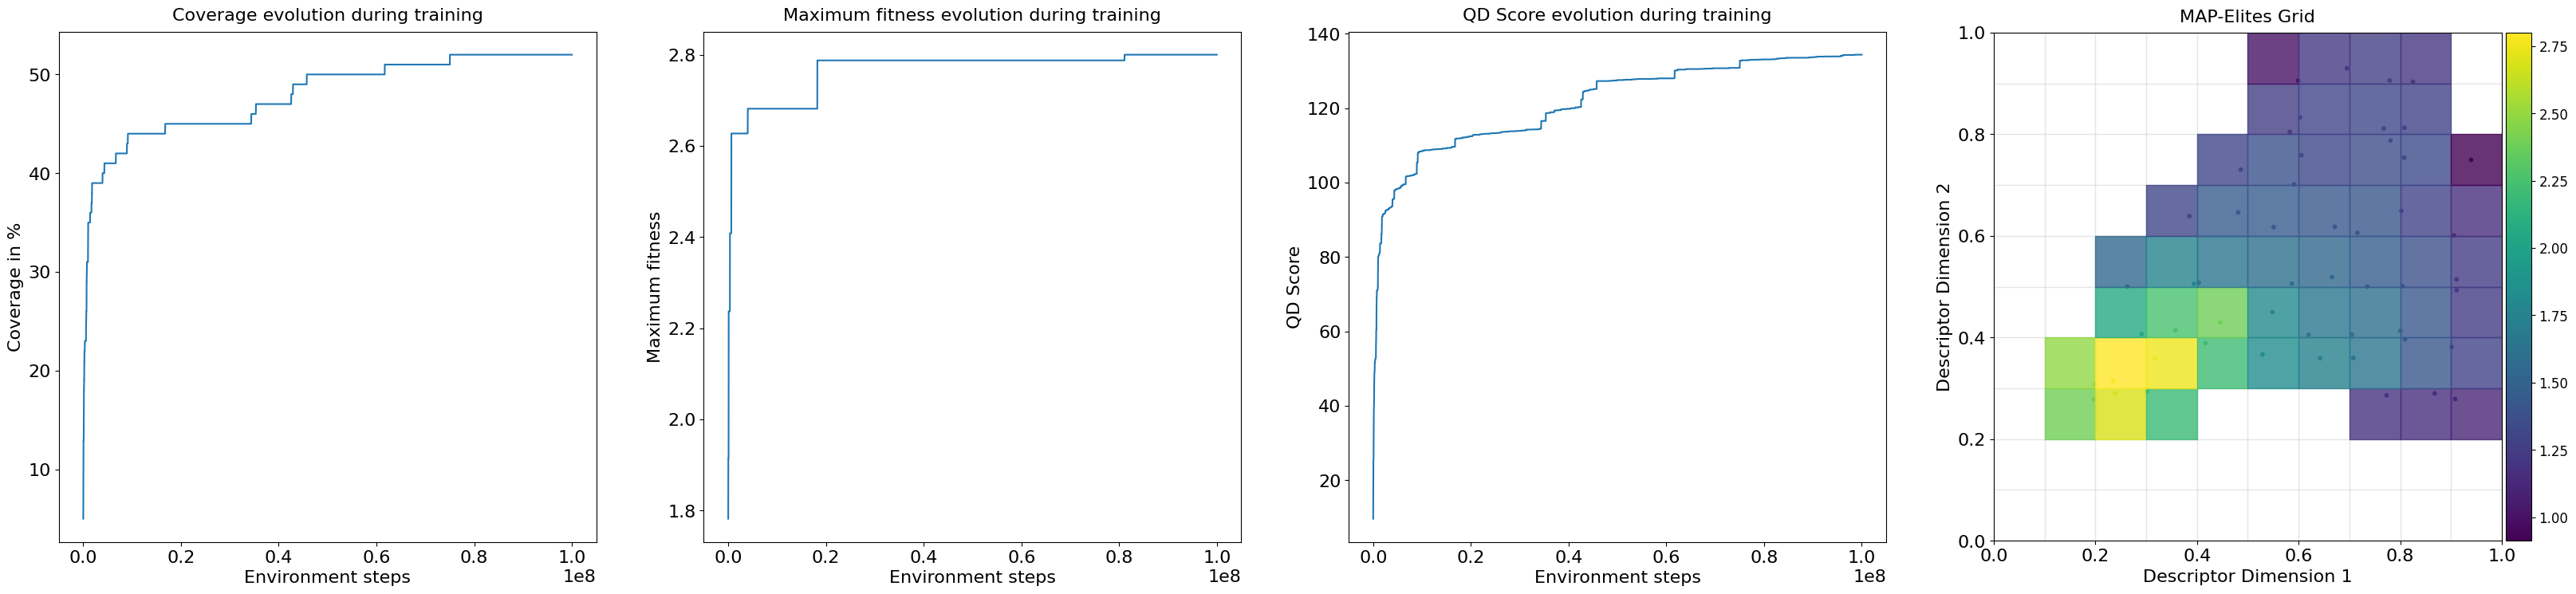

In [ ]:
# Create the x-axis array
env_steps = metrics["iteration"] * batch_size * episode_length * config["NUM_ENVS"]
#print(jnp.max(env_steps))
#print(jnp.max(metrics["iteration"]))

%matplotlib inline
# Create the plots and the grid
fig, axes = plot_map_elites_results(env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_descriptor=min_descriptor, max_descriptor=max_descriptor)

In [25]:
best_idx = jnp.argmax(repertoire.fitnesses)
best_fitness = jnp.max(repertoire.fitnesses)
best_descriptor = repertoire.descriptors[best_idx]
print(
    f"Best fitness in the repertoire: {best_fitness:.2f}\n",
    f"Descriptor of the best individual in the repertoire: {best_descriptor}\n",
    f"Index in the repertoire of this individual: {best_idx}\n"
)

Best fitness in the repertoire: 2.80
 Descriptor of the best individual in the repertoire: [0.2344596 0.3142916]
 Index in the repertoire of this individual: 32



In [26]:
# select the parameters of the best individual
my_params = jax.tree.map(
    lambda x: x[best_idx],
    repertoire.genotypes
)

In [ ]:
def preprocess_obs_with_id(obs_dict, env):
    """Simulate CTRolloutManager's preprocessing by adding one-hot agent IDs."""
    new_obs_dict = {}
    num_agents = len(env.agents)
    for i, agent in enumerate(env.agents):
        obs = obs_dict[agent].flatten()
        one_hot = jax.nn.one_hot(i, num_classes=num_agents)
        new_obs_dict[agent] = jnp.concatenate([obs, one_hot])
    return new_obs_dict


def visualize_recurrent_policy(trained_params, env, config):
    rng = jax.random.PRNGKey(config["SEED"])
    rng, rng = jax.random.split(rng)
    #wrapped_env = CTRolloutManager(env, batch_size=1)

    network = RNNQNetwork(
        action_dim=env.action_space(env.agents[0]).n,
        hidden_dim=config["HIDDEN_SIZE"],
    )
    
    # Reset environment
    obs, env_state = env.reset(rng)

    dones = {agent: jnp.array(False) for agent in env.agents}
    hstate = ScannedRNN.initialize_carry(
        config["HIDDEN_SIZE"], len(env.agents), 1
    )
    
    # Collect all environment states
    returns = {agent: 0.0 for agent in env.agents}
    state_seq = []
    max_steps = config["NUM_STEPS"]

    for step in range(max_steps):
        # Compute Q-values
        # Prepare inputs for network
        obs = preprocess_obs_with_id(obs, env)
        _obs = batchify(obs)         # (num_agents, obs_dim)
        _obs = _obs[:, None, :]                      # (num_agents, 1, obs_dim)

        _dones = jnp.stack([jnp.array([dones[agent]]) for agent in env.agents])  # shape (num_agents, 1)
        _dones = jnp.expand_dims(_dones, axis=-1)  # from (3, 1) to (3, 1, 1)

        #print("_obs.shape:", _obs.shape)
        #print("_dones.shape:", _dones.shape)
        #print("hstate.shape:", hstate.shape)

        def apply_fn(h, o, d):
            return network.apply(trained_params, h, o, d)

        hstate, q_vals = jax.vmap(apply_fn, in_axes=(0, 0, 0))(
            hstate,
            _obs,
            _dones,
        )
        #print("hstate.shape:", hstate.shape)

        #hstate = hstate[:, None, :]  # Already in (num_agents, hidden_dim)
        q_vals = q_vals.squeeze(axis=1)  # (num_agents, num_envs, num_actions) remove the time dim
        #print("q_vals.shape", q_vals.shape)
        
        actions = {}
        avail_actions = env.get_avail_actions(env_state.env_state)

        for i, agent in enumerate(env.agents):
            avail_agent = avail_actions[agent][None, None, :]  # shape (1, 1, n_actions)
            #print("avail_agent.shape", avail_agent.shape)
            
            unavail_actions = 1 - avail_agent  # shape (1, 1, n_actions)
            
            # Select Q-values for this agent only
            q_agent = q_vals[i][None, None, :]  # shape (1, 1, n_actions)
            q_masked = q_agent - (unavail_actions * 1e10)

            action = jnp.argmax(q_masked, axis=-1)  # shape (1, 1)
            action = action.squeeze()               # scalar
            #print("action.shape", action.shape)

            # Wrap in array with batch dim
            actions[agent] = int(action)    # shape (1,)
        
        #rng, rng_s = jax.random.split(rng)
        state_seq.append((rng, env_state.env_state, actions))

        # Step environment
        obs, env_state, rewards, dones, infos = env.step(rng, env_state, actions)
        returns = {a: returns[a] + rewards[a] for a in env.agents}
        
        if dones["__all__"]:
            break

    # Visualization
    print("Returns:", returns)

    viz = SMAXVisualizer(env, state_seq)
    viz.animate(view=False, save_fname="trained_qmix_rnn.gif")

Returns: {'ally_0': Array(2., dtype=float32), 'ally_1': Array(2., dtype=float32), 'ally_2': Array(2., dtype=float32), 'ally_3': Array(2., dtype=float32), 'ally_4': Array(2., dtype=float32)}


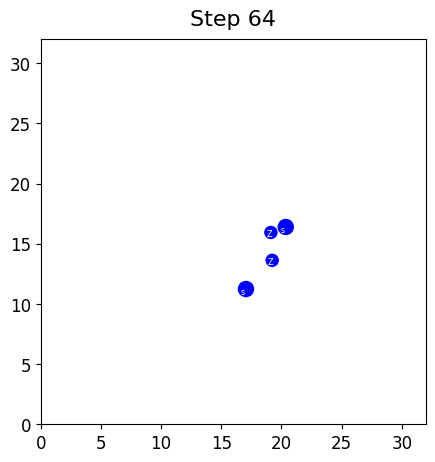

In [29]:
scenario = map_name_to_scenario(config["MAP_NAME"])
#env = HeuristicEnemySMAX(scenario=scenario, **config["ENV_KWARGS"])
#env = SMAXLogWrapper(env)
env = wrapped_env

visualize_recurrent_policy(my_params['agent'], env, config)

In [30]:
import pickle
from flax.serialization import to_state_dict
from flax.serialization import from_state_dict


def save_repertoire(repertoire: MapElitesRepertoire, filepath: str):
    # Convert the object to a savable dictionary
    state_dict = {
        "genotypes": to_state_dict(repertoire.genotypes),
        "fitnesses": repertoire.fitnesses,
        "descriptors": repertoire.descriptors,
        "centroids": repertoire.centroids,
        "extra_scores": to_state_dict(repertoire.extra_scores),
        "keys_extra_scores": repertoire.keys_extra_scores,
    }
    
    with open(filepath, "wb") as f:
        pickle.dump(state_dict, f)

def load_repertoire(filepath: str) -> MapElitesRepertoire:
    with open(filepath, "rb") as f:
        state_dict = pickle.load(f)

    # Rebuild the object using the saved state
    genotypes = from_state_dict(state_dict["genotypes"], state_dict["genotypes"])
    extra_scores = from_state_dict(state_dict["extra_scores"], state_dict["extra_scores"])

    return MapElitesRepertoire(
        genotypes=genotypes,
        fitnesses=state_dict["fitnesses"],
        descriptors=state_dict["descriptors"],
        centroids=state_dict["centroids"],
        extra_scores=extra_scores,
        keys_extra_scores=state_dict["keys_extra_scores"],
    )

In [31]:
#import os

#os.makedirs("/vol/bitbucket/eww24/Masters_project/repertoire", exist_ok=True)

filepath = "/vol/bitbucket/eww24/Masters_project/repertoire/qmix_transfer_repertoire_2s3z_v2_epoch_10.pkl"
save_repertoire(repertoire, filepath)
print("saved reportoire")

saved reportoire


In [32]:
loaded_repertoire = load_repertoire(filepath)
print("Repertoire loaded successfully.")

Repertoire loaded successfully.


In [33]:
best_idx = jnp.argmax(loaded_repertoire.fitnesses)
best_fitness = jnp.max(loaded_repertoire.fitnesses)
best_descriptor = loaded_repertoire.descriptors[best_idx]
print(
    f"Best fitness in the repertoire: {best_fitness:.2f}\n",
    f"Descriptor of the best individual in the repertoire: {best_descriptor}\n",
    f"Index in the repertoire of this individual: {best_idx}\n"
)

Best fitness in the repertoire: 2.80
 Descriptor of the best individual in the repertoire: [0.2344596 0.3142916]
 Index in the repertoire of this individual: 32

